In [1]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import src.seed as seed
import src.models as models
import src.functions as fn

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import time

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
# needs kaleido to work 
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+png"

In [2]:
device = seed.device
generator = seed.generator

X, y, X_test, y_test = fn.load_cifar_10()

Files already downloaded and verified
Files already downloaded and verified


C:\Users\Eric\DSC Capstone\Investigating-NN-Optimizers\src\functions.py:82: UserWarning:

expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)



In [3]:
from torch.utils.data import TensorDataset, DataLoader

In [5]:
# Model Parameters
input_size = X.shape[1] * X.shape[2] * X.shape[3]
num_hidden_layers = 2
hidden_layer_size = 200

output_dir = "eos/sgd_EC"
num_labels = 10

In [6]:
# Dataloader for SGD
batch_size = 128

train_dataset = TensorDataset(X, y)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=seed.cpu_generator
)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Single Model Tests

In [27]:
# Training Parameters
epochs = 2000
learning_rate = 0.05
accuracy = 0.999

model = models.FullyConnectedNet(
    input_size=input_size,
    num_hidden_layers=num_hidden_layers,
    hidden_layer_size=hidden_layer_size,
    num_labels=10,
    activation=nn.Tanh
)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0)

# Train with mini-batch SGD, compute Hessian on full batch
fn.train_minibatch_sgd_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    accuracy=accuracy,
    train_loader=train_loader,
    test_loader=test_loader,
    X_full=X,
    y_full=y,
    output_dir=output_dir
)

Training FullyConnectedNet with SGD and learning rate 0.05 for 2000 epochs.
Epoch [100/2000], Loss: 0.0396, Batch Sharp: 28.09, Full Sharp: 26.16, Train Acc: 0.8458
Epoch [200/2000], Loss: 0.0229, Batch Sharp: 31.67, Full Sharp: 32.49, Train Acc: 0.9492
Epoch [300/2000], Loss: 0.0148, Batch Sharp: 39.85, Full Sharp: 36.50, Train Acc: 0.9812
Epoch [400/2000], Loss: 0.0098, Batch Sharp: 40.93, Full Sharp: 40.02, Train Acc: 0.9914
Epoch [500/2000], Loss: 0.0070, Batch Sharp: 41.46, Full Sharp: 38.42, Train Acc: 0.9942
Completed training of FullyConnectedNet with SGD and learning rate 0.05. Took 541 epochs and 133.3 seconds. Final training accuracy: 0.9992; Final testing accuracy: 0.2570
Saved with model_id 2


In [28]:
md, out = fn.load_output_files(output_dir)

In [29]:
def plot_sharpness(metadata, output, model_id, include_eos_threshold=True):
    # filter model_id
    metadata = metadata[metadata['model_id']==model_id]
    output = output[output['model_id']==model_id]
    
    # metrics
    optimizer = metadata['optimizer'].iloc[0]
    learning_rate = metadata['learning_rate'].iloc[0]
    criterion = metadata['criterion'].iloc[0]

    # figure creation
    fig = px.line(output, x='epoch', y=['sharpness_H_batch', 'sharpness_H_full'], 
                     labels={
                         "epoch": "Epoch",
                         # "sharpness_H": "Sharpness",
                     },
                     title=f"Sharpness of {optimizer} training with {learning_rate} learning rate and {criterion} criterion")
    
    if include_eos_threshold:
        fig.add_hline(y=2 / learning_rate, line_dash="dash", line_color="red")
    
    return fig

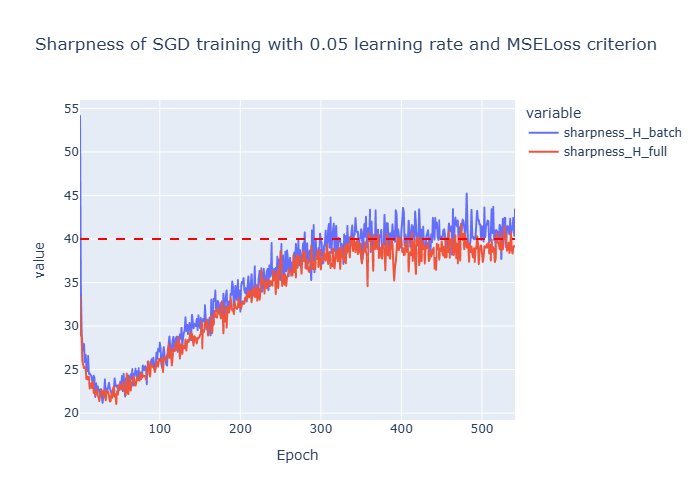

In [30]:
plot_sharpness(metadata=md, output=out, model_id=2)

In [33]:
def plot_accuracy(metadata, output, model_id, include_eos_threshold=True):
    # filter model_id
    metadata = metadata[metadata['model_id']==model_id]
    output = output[output['model_id']==model_id]

    # metametrics
    optimizer = metadata['optimizer'].iloc[0]
    learning_rate = metadata['learning_rate'].iloc[0]
    criterion = metadata['criterion'].iloc[0]

    # figure creation
    fig = px.scatter(output, x='epoch', y=['train_accuracy', 'test_accuracy'],
                     labels={
                         "epoch": "Epoch",
                         "train_accuracy": "Train Accuracy",
                         "test_accuracy": "Test Accuracy",
                         'value': 'Accuracy',
                     },
                     title=f"Accuracy of {optimizer} training with {learning_rate} learning rate and {criterion} criterion")

    return fig

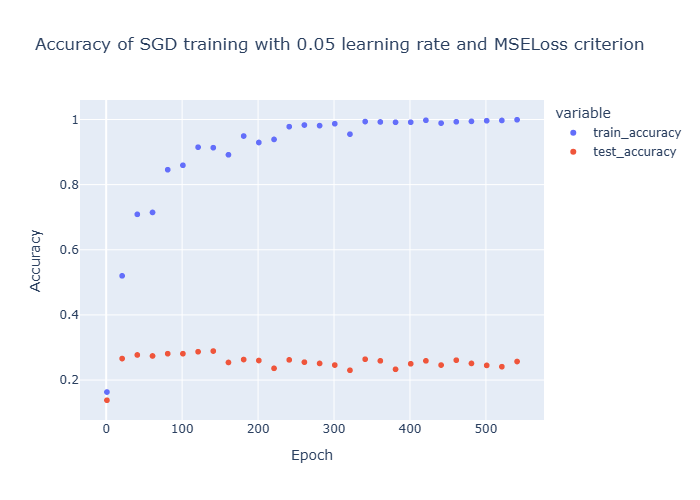

In [34]:
plot_accuracy(metadata=md, output=out, model_id=2)

# Multi-Model Tests

In [35]:
# Using the training params as above (minus lr)
epochs = 1000
accuracy = 1.1  # prevents early stopping

# custom lr list
learning_rate_list = [2/500, 2/250, 2/100, 2/50, 2/25, 2/20, 2/10, 2/5]
for lr in learning_rate_list:
    # initialize model
    model = models.FullyConnectedNet(
        input_size=input_size,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        num_labels=10,
        activation=nn.Tanh
    )
    criterion = nn.MSELoss()
    
    # Use optimizer with lr
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)
    
    # Train model
    fn.train_minibatch_sgd_model(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        accuracy=accuracy,
        train_loader=train_loader,
        test_loader=test_loader,
        X_full=X,
        y_full=y,
        output_dir=output_dir
    )

Training FullyConnectedNet with SGD and learning rate 0.004 for 1000 epochs.
Epoch [100/1000], Loss: 0.0855, Batch Sharp: 28.65, Full Sharp: 27.61, Train Acc: 0.4286
Epoch [200/1000], Loss: 0.0709, Batch Sharp: 28.62, Full Sharp: 26.21, Train Acc: 0.5912
Epoch [300/1000], Loss: 0.0629, Batch Sharp: 27.48, Full Sharp: 25.67, Train Acc: 0.6896
Epoch [400/1000], Loss: 0.0575, Batch Sharp: 26.27, Full Sharp: 25.86, Train Acc: 0.7544
Epoch [500/1000], Loss: 0.0528, Batch Sharp: 27.22, Full Sharp: 27.05, Train Acc: 0.8046
Epoch [600/1000], Loss: 0.0495, Batch Sharp: 27.85, Full Sharp: 27.24, Train Acc: 0.8400
Epoch [700/1000], Loss: 0.0463, Batch Sharp: 27.73, Full Sharp: 28.47, Train Acc: 0.8640
Epoch [800/1000], Loss: 0.0435, Batch Sharp: 29.94, Full Sharp: 27.83, Train Acc: 0.8872
Epoch [900/1000], Loss: 0.0408, Batch Sharp: 28.26, Full Sharp: 29.13, Train Acc: 0.9052
Epoch [1000/1000], Loss: 0.0386, Batch Sharp: 31.71, Full Sharp: 30.25, Train Acc: 0.9210
Completed training of FullyConne

In [36]:
md, out = fn.load_output_files(output_dir)

In [56]:
def plot_eos_analysis(metadata, output, model_ids, include_eos_threshold=True):
    # Create subplots: Row 1 = Loss, Row 2 = Sharpness
    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=("Training Loss (Log Scale)", "Batch Sharpness (Hessian λ_max)", "Full Sharpness (Hessian λ_max)")
    )

    # Color palette for different models
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']
    
    # Misc. graph limits
    max_epoch = metadata[metadata['model_id'].isin(model_ids)]['num_epochs'].max()
    y_limit = output[output['model_id'].isin(model_ids)]['sharpness_H_batch'].max() * 1.1
    
    for i, m_id in enumerate(model_ids):
        # Filter data for this specific model
        m_meta = metadata[metadata['model_id'] == m_id].iloc[0]
        m_data = output[output['model_id'] == m_id]

        lr = m_meta['learning_rate']
        name = f"LR={lr}"
        color = colors[i % len(colors)]

        # Plot Training Loss
        fig.add_trace(
            go.Scatter(x=m_data['epoch'], y=m_data['train_loss'],
                       name=name, mode='lines', line=dict(width=1, color=color),
                       legendgroup=name),
            row=1, col=1
        )

        # Plot Batch Sharpness
        fig.add_trace(
            go.Scatter(x=m_data['epoch'], y=m_data['sharpness_H_batch'],
                       name=name, mode='lines', line=dict(width=1, color=color),
                       legendgroup=name, showlegend=False),
            row=2, col=1
        )

        # Plot Full Sharpness
        fig.add_trace(
            go.Scatter(x=m_data['epoch'], y=m_data['sharpness_H_full'],
                       name=name, mode='lines', line=dict(width=1, color=color),
                       legendgroup=name, showlegend=False),
            row=3, col=1
        )

        # Add the EoS Threshold (2 / learning_rate)
        if include_eos_threshold:
            eos_val = 2.0 / lr
            fig.add_shape(
                type="line", line=dict(color=color, dash="dash", width=2),
                x0=0, x1=max_epoch,
                y0=eos_val, y1=eos_val,
                row=2, col=1
            )
            # Label for the threshold
            fig.add_annotation(
                x=max_epoch, y=eos_val,
                text=f"2/η ≈ {eos_val:.1f}", showarrow=False,
                yshift=10, row=2, col=1, font=dict(color=color)
            )

            fig.add_shape(
                type="line", line=dict(color=color, dash="dash", width=2),
                x0=0, x1=max_epoch,
                y0=eos_val, y1=eos_val,
                row=3, col=1
            )
            # Label for the threshold
            fig.add_annotation(
                x=max_epoch, y=eos_val,
                text=f"2/η ≈ {eos_val:.1f}", showarrow=False,
                yshift=10, row=3, col=1, font=dict(color=color)
            )

    # Update Layout
    fig.update_yaxes(type="log", title_text="Loss", row=1, col=1)
    fig.update_yaxes(title_text="λ_max (Batch Hessian)", range=[0, y_limit], row=2, col=1)
    # fig.update_xaxes(title_text="Epoch", row=2, col=1)

    fig.update_yaxes(title_text="λ_max (Full Hessian)", range=[0, y_limit], row=3, col=1)
    fig.update_xaxes(title_text="Epoch", row=3, col=1)

    fig.update_layout(
        height=800,
        title_text="Edge of Stochastic Stability Analysis",
        template="plotly_white",
        hovermode="x unified"
    )

    return fig

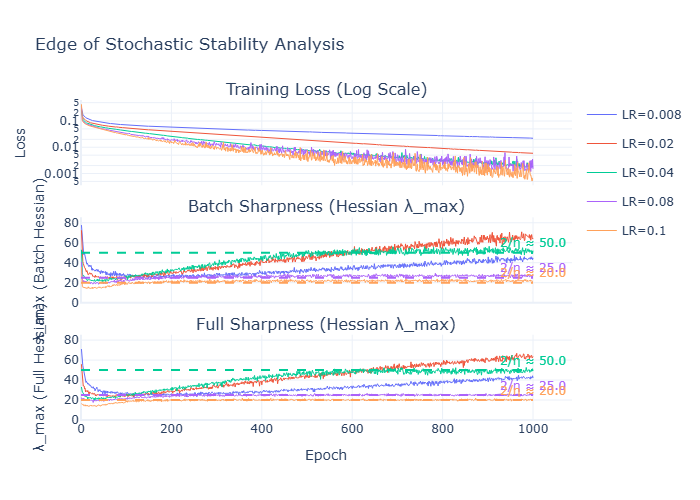

In [57]:
plot_eos_analysis(metadata=md, output=out, model_ids=[4, 5, 6, 7, 8])

## Batch size analysis

In [59]:
# Using the training params as above (minus lr)
epochs = 1000
accuracy = 1.1

# Varying Batch sizes
batch_size_list = [16, 32, 64, 128, 256]
for bs in batch_size_list:
    # Set up dataloader
    train_dataset = TensorDataset(X, y)
    train_loader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        generator=seed.cpu_generator
    )
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # initialize model
    model = models.FullyConnectedNet(
        input_size=input_size,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        num_labels=10,
        activation=nn.Tanh
    )
    criterion = nn.MSELoss()

    # Use optimizer with lr=0.05 (2/40)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.0)

    # Train model (FULL HESSIAN)
    fn.train_minibatch_sgd_model(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        accuracy=accuracy,
        train_loader=train_loader,
        test_loader=test_loader,
        X_full=X,
        y_full=y,
        output_dir=output_dir
    )

Training FullyConnectedNet with SGD and learning rate 0.05 for 1000 epochs.
Epoch [100/1000], Loss: 0.0064, Batch Sharp: 39.44, Full Sharp: 27.39, Train Acc: 0.9978
Epoch [200/1000], Loss: 0.0014, Batch Sharp: 46.53, Full Sharp: 31.58, Train Acc: 0.9998
Epoch [300/1000], Loss: 0.0005, Batch Sharp: 49.40, Full Sharp: 32.54, Train Acc: 0.9998
Epoch [400/1000], Loss: 0.0002, Batch Sharp: 51.49, Full Sharp: 32.78, Train Acc: 1.0000
Epoch [500/1000], Loss: 0.0001, Batch Sharp: 51.68, Full Sharp: 33.42, Train Acc: 1.0000
Epoch [600/1000], Loss: 0.0000, Batch Sharp: 54.30, Full Sharp: 33.17, Train Acc: 1.0000
Epoch [700/1000], Loss: 0.0000, Batch Sharp: 52.52, Full Sharp: 31.99, Train Acc: 1.0000
Epoch [800/1000], Loss: 0.0000, Batch Sharp: 52.03, Full Sharp: 34.59, Train Acc: 1.0000
Epoch [900/1000], Loss: 0.0000, Batch Sharp: 53.82, Full Sharp: 34.19, Train Acc: 1.0000
Epoch [1000/1000], Loss: 0.0000, Batch Sharp: 54.39, Full Sharp: 33.99, Train Acc: 1.0000
Completed training of FullyConnec

In [63]:
md, out = fn.load_output_files(output_dir)

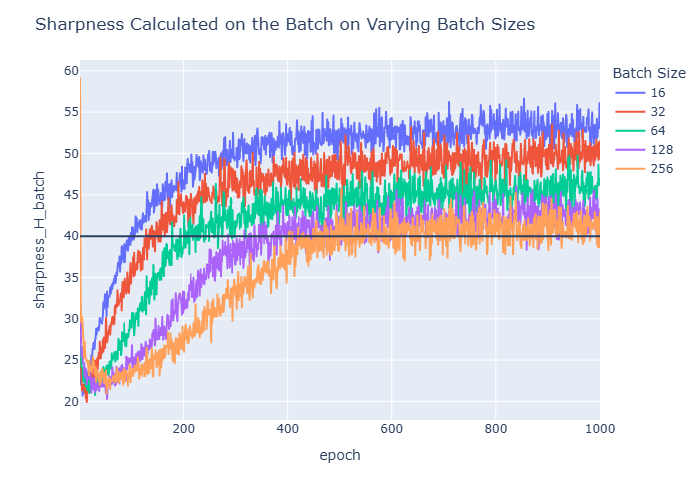

In [68]:
batch_map = {
             11: 16,
             12: 32,
             13: 64,
             14: 128,
             15: 256}

out = out[out['model_id'].isin([11,12,13,14,15])]
out['Batch Size'] = out['model_id'].map(batch_map)

fig = px.line(out, x='epoch', y='sharpness_H_batch', color='Batch Size')
fig.add_hline(2/0.05)
fig.update_layout(title_text="Sharpness Calculated on the Batch on Varying Batch Sizes")
fig.show()

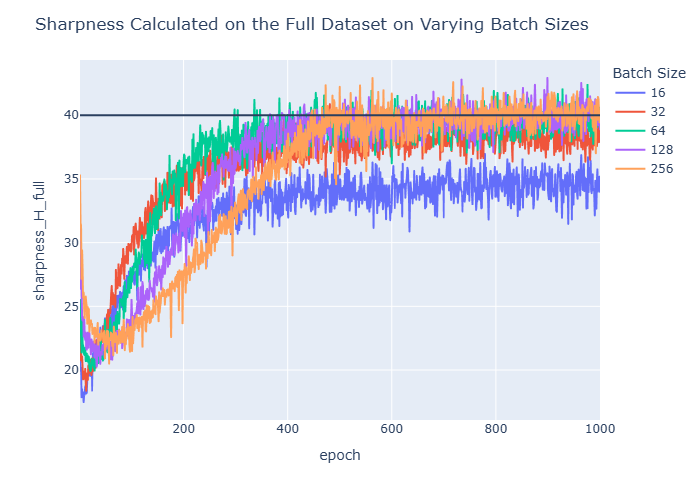

In [69]:
fig = px.line(out, x='epoch', y='sharpness_H_full', color='Batch Size')
fig.add_hline(2/0.05)
fig.update_layout(title_text="Sharpness Calculated on the Full Dataset on Varying Batch Sizes")
fig.show()

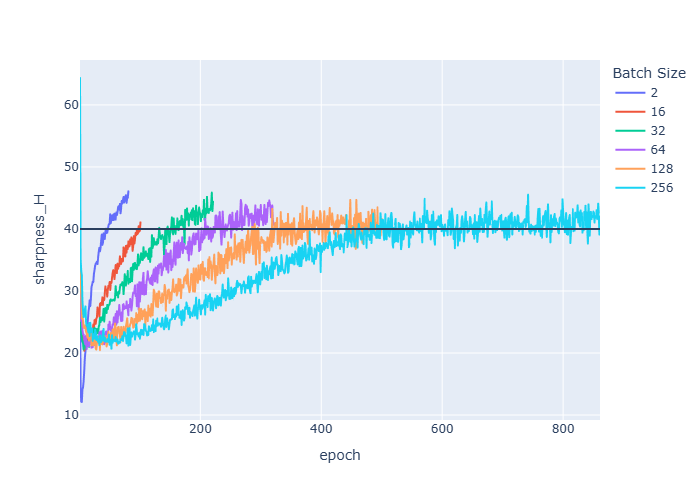

In [26]:
md, out = fn.load_output_files(output_dir)
batch_map = {48: 2,
             49: 16,
             50: 32,
             51: 64,
             52: 128,
             53: 256}

out = out[out['model_id'].isin([48, 49, 50, 51, 52, 53])]
out['Batch Size'] = out['model_id'].map(batch_map)

fig = px.line(out, x='epoch', y='sharpness_H', color='Batch Size')
fig.add_hline(40)
fig.show()